[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/{user_name}/{repo_name}/blob/{branch_name}/path/to/notebook.ipynb)


## LangChain 

LangChain is a powerful framework built around large language models (LLMs), which allows us to create a wide range of natural language processing (NLP) applications. With LangChain, we can create chatbots, generative question-answering systems, summarization models, and much more.

The core idea behind LangChain is that we can "chain" together different components to create more advanced use cases around LLMs. For example, we might use one component to preprocess text data, another to fine-tune a pre-trained LLM on a specific task, and another to generate responses or summaries based on the input.

One of the key benefits of LangChain is its flexibility. It allows us to experiment with different combinations of components and adjust their parameters to optimize performance on specific tasks. Moreover, since it's built around LLMs, we can easily integrate it with other NLP libraries, such as Hugging Face Transformers.

In summary, LangChain is a powerful tool for building advanced NLP applications using LLMs. With its flexible and modular architecture, we can easily create custom pipelines to solve a wide range of NLP tasks.

[LangChain DOCS](https://python.langchain.com/en/latest/)


### AIM
This notebook aims to guide you to create your own Chatbot that will be able to query a document give answers based on that document and also give sources of how it came about that answer

### 1. Initial setup 
we will need to install the following packages

In [ ]:
!pip install langchain
!pip install openai
!pip install unstructured
!pip install unstructured[local-inference]
!pip install pinecone-client
!pip install tqdm

we will need tesseract as well as langchain document loader requires this you need to download this package and complete its setup the following are the links

- [Download 64bit](https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-w64-setup-5.3.0.20221222.exe)
- [Download 32bit](https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-w32-setup-5.3.0.20221222.exe)
- [Tesseract WIKI](https://github.com/UB-Mannheim/tesseract/wiki)

After the installation specify the correct path similar to the one given below

In [1]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

### 2. Loading our Document
In this example we will be loading a PDF document but you can load other types of files as well see the [DOCS](https://python.langchain.com/en/latest/modules/document_loaders/how_to_guides.html)

PDF documents can be either loaded locally or from a url depending on your requirements comment the code


In [2]:
from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader
loader = UnstructuredPDFLoader("HydrogenFuel.pdf")
# loader = OnlinePDFLoader("https://wolfpaulus.com/wp-content/uploads/2017/05/field-guide-to-data-science.pdf")

data = loader.load()
print (f'You have {len(data)} document(s) in your data')
print (f'There are {len(data[0].page_content)} characters in your document')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 182.31it/s]

You have 1 document(s) in your data
There are 67821 characters in your document


### 3. Chunk your data up into smaller documents
Although GPT models are very powerful, they do have some limitations when it comes to processing large amounts of data. One of the main limitations is related to the size of the model and its memory constraints. GPT models consist of multiple layers of neural networks that require a significant amount of memory to store all the parameters. This means that the larger the model, the more memory it needs to process the data. When we give a large amount of data to a GPT model, it can quickly run out of memory, leading to errors or crashes.

To overcome these limitations, it's often necessary to preprocess the data and divide it into smaller batches that the GPT model can handle that is what the below cell will do it will split data into 1000 characters chunk size you can play around with this number

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(data)
print (f'Now you have {len(texts)} documents')

Now you have 92 documents


In [4]:
# to see a chuck of our document we loaded do the following
texts[1]

Document(page_content='National Renewable Energy Laboratory\n\nDenver West Parkway Golden, CO\n\n-\n\n-\n\n• www.nrel.gov\n\nThis report is available at no cost from the National Renewable Energy Laboratory (NREL) at www.nrel.gov/publications.\n\nThis work was authored in part by the National Renewable Energy Laboratory, operated by Alliance for Sustainable Energy, LLC, for the U.S. Department of Energy (DOE) under Contract No. DE-AC36-08GO28308. Funding provided by U.S. Department of Energy Office of Energy Efficiency and Renewable Energy Fuel Cell Technologies Office. The views expressed herein do not necessarily represent the views of the DOE or the U.S. Government.\n\nThis report is available at no cost from the National Renewable Energy Laboratory (NREL) at www.nrel.gov/publications.\n\nCover Photo by Vanessa Arjona: NREL 60272.\n\nAcknowledgments', lookup_str='', metadata={'source': 'HydrogenFuel.pdf'}, lookup_index=0)

### 4. Create embeddings of your documents to get ready for semantic search
In natural language processing, embeddings are used to represent words and text data in a numerical form that can be used as input to machine learning models.

An embedding is a learned representation of a word or phrase that captures its meaning and context in a given language. This is usually achieved through unsupervised learning techniques, such as word2vec or GloVe, which use large amounts of text data to learn a dense vector representation for each word in the vocabulary. The resulting embeddings can then be used as input to various NLP tasks, such as text classification or machine translation.

For our task we will call on embeddings API provided by OPEN AI it supports upto **1536** embeddings

In [5]:
from langchain.embeddings.openai import OpenAIEmbeddings
OPENAI_API_KEY= "...YOUR...API...KEY..."

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

### 5. Uploading our embeddings to a database
We will be using [Pinecone](https://www.pinecone.io/)

Pinecone is a managed database designed for vector data. It is specifically optimized for storing and querying high-dimensional vector data, such as embeddings generated by natural language processing (NLP) models or image processing models.

First create a Pinecone Index(database)

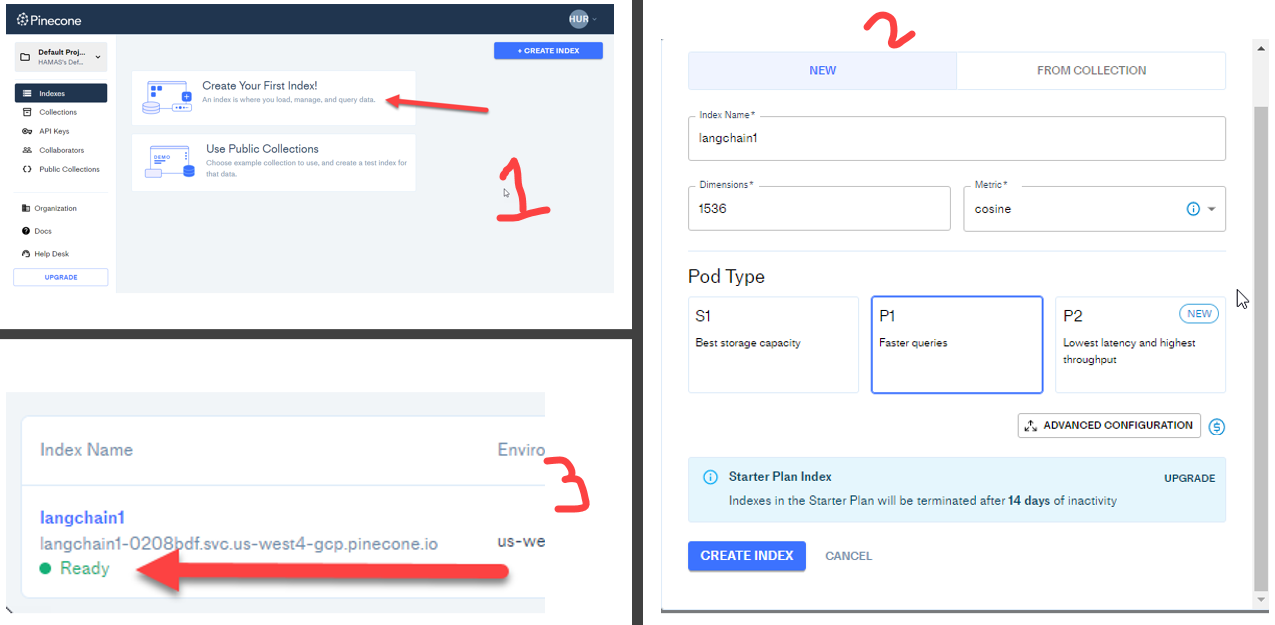

In [6]:
from langchain.vectorstores import Chroma, Pinecone
import pinecone
PINECONE_API_KEY = '...YOUR API KEY...'
PINECONE_API_ENV = '...YOUR ENV NAME...'
index_name = "...YOUR INDEX NAME..." #in the image above our index name is langchain1

pinecone.init(
    api_key=PINECONE_API_KEY, 
    environment=PINECONE_API_ENV
)

docsearch = Pinecone.from_texts([t.page_content for t in texts], embeddings, index_name=index_name)

### 6. Check your Data
To check our data we will do a similarity check to see can it fetch data related to our document

In [7]:
query = input("Ask Me anything from the document you uploaded: ")
docs = docsearch.similarity_search(query, include_metadata=True)
docs[1]

Ask Me anything from the document you uploaded: what is a hydrogen fuel cell


Document(page_content='This project meeting engaged stakeholders from various areas within the data center and hydrogen and fuel cells industries to discuss the suitability and needs of hydrogen fuel cell systems in supplying prime or backup power to critical loads of data centers. By bringing together knowledgeable stakeholders from data center as well as hydrogen storage and fuel cell industries, this workshop aimed to identify the research and development needs to enable hydrogen fuel cells to be a competitive technology in providing power to data centers.', lookup_str='', metadata={}, lookup_index=0)

### 7. Creating our Question Answer ChatBot

In [8]:
from langchain.llms import OpenAI
from langchain import VectorDBQA

llm = OpenAI(
    temperature=0.7, # This values controls the randomness in the response the closer to 1 the more random responses
    openai_api_key=OPENAI_API_KEY)

qa = VectorDBQA.from_chain_type(llm=llm, chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
  
while (True):
    query = input("Ask me: ")
    if (query.lower()=="quit"):
        break
    result = qa({"query": query})
    
    print(f"\n\nResponse:{result['result']}\n")
    print("Sources:\n\n")
    for i in result['source_documents']:
        print (f'{i}\n')

C:\Users\hamas\.conda\envs\ml\lib\site-packages\langchain\chains\retrieval_qa\base.py:152: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


Ask me: what is a hydrogen fuel cell


Response: A hydrogen fuel cell is a device that converts the energy from a reaction between hydrogen and oxygen into electrical energy.

Sources:


page_content='10 Some fuel cell varieties internally reform natural gas and require a feedstock such as natural gas or biogas. Other varieties use external reforming of natural gas and the fuel cell stack is fed pure hydrogen and air. Fuel cell varieties where the stack uses pure hydrogen could run off natural gas or hydrogen, but individual companies may not offer all configurations.\n\nUninterruptable power supply battery sizes would be significantly reduced, therefore lowering capital and maintenance cost and time.\n\nLiquid\n\ncooled data centers could make use of low\n\nquality heat for data center cooling dehumidification.\n\nMoving to a DC bus and reducing the building electrical infrastructure dramatically reduces the heat loads in the data center and would increase electrical efficiency for me

#### To have the bot retain memory you can do this

In [9]:
from langchain import ConversationChain
conversation = ConversationChain(llm = llm)

while (True):
    query = input("Ask me: ")
    if (query.lower()=="quit"):
        break
    print(f"\nResponse: {conversation.predict(input=query)}\n\n")

Ask me: what is a hydrogen fuel cell

Response:  A hydrogen fuel cell is an energy storage system that converts chemical energy from stored hydrogen into electricity through an electrochemical reaction. It is a clean and efficient way of producing electricity that can be used to power electric vehicles, homes, and businesses.


Ask me: what did I ask you earlier

Response:  You asked me what a hydrogen fuel cell is.


Ask me: can you give more topics that can relate to this

Response:  Sure! Hydrogen fuel cells can be used to power electric vehicles, homes, and businesses, and they can also be used to store energy for the grid. Additionally, hydrogen fuel cells are often used in industries such as aerospace, automotive, and marine. They can also be used to power remote locations that are far from traditional electricity sources.


Ask me: are their other cells?

Response:  Yes, there are other types of fuel cells, such as proton exchange membrane fuel cells (PEMFC), direct methanol fue